# Classical Transformer


In [1]:
import os
import math
import random
from typing import Callable, Iterable
from copy import deepcopy
import numpy as np
from time import time

from tqdm import tqdm

from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch import Tensor, device
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer

from torchtext.vocab import Vocab
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset
from torchtext.vocab import build_vocab_from_iterator

import tensorflow as tf

f:\web-dev\qt\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
f:\web-dev\qt\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
f:\web-dev\qt\Lib\site-packages\torchtext\datasets\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last releas

## Setting up environment


In [2]:
dev = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

print(dev)

seed = 42

os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

os.environ["OMP_NUM_THREADS"] = str(os.cpu_count())
os.environ["TF_NUM_INTEROP_THREADS"] = str(os.cpu_count())
os.environ["TF_NUM_INTRAOP_THREADS"] = str(os.cpu_count())

tf.config.threading.set_intra_op_parallelism_threads(os.cpu_count())
tf.config.threading.set_inter_op_parallelism_threads(os.cpu_count())

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


## Helper functions


### Binary Accuracy


In [3]:
def binary_accuracy(preds: Tensor, y: Tensor):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # round predictions to the closest integer
    rounded_preds = preds.sigmoid().round()
    correct = (rounded_preds == y).float()  # convert into float for division
    acc = correct.sum() / len(correct)
    return acc

### Clone Model


In [4]:
def get_clones(module: nn.Module, N: int):
    return nn.ModuleList([deepcopy(module) for _ in range(N)])

### Data Loader


In [5]:
def yield_tokens(data: list[tuple[int, str]], tokenizer: Callable[[str], list[str]]):
    for label, text in data:
        yield tokenizer(text.lower())


def text_transform(text: str, vocab: Vocab, tokenizer: Callable[[str], list[str]]):
    return vocab([token for token in tokenizer(text.lower())])


def label_transform(label: int):
    return torch.tensor(1.0 if label == 2 else 0.0, dtype=torch.float)


def collate_batch(
    batch: Iterable[tuple[int, str]],
    vocab: Vocab,
    tokenizer: Callable[[str], list[str]],
):
    pad_idx = vocab["<pad>"]
    label_list, text_list = [], []

    for label, text in batch:
        label_list.append(label_transform(label))
        processed_text = torch.tensor(text_transform(text, vocab, tokenizer))
        text_list.append(processed_text)
    return torch.tensor(label_list), pad_sequence(text_list, padding_value=pad_idx)


def batch_sampler(data: list, batch_size: int, tokenizer: Callable[[str], list[str]]):
    indices = [(i, len(tokenizer(s[1]))) for i, s in enumerate(data)]
    random.shuffle(indices)
    pooled_indices = []
    # create pool of indices with similar lengths
    for i in range(0, len(indices), batch_size * 100):
        pooled_indices.extend(
            sorted(indices[i : i + batch_size * 100], key=lambda x: x[1])
        )

    pooled_indices = [x[0] for x in pooled_indices]

    # yield indices for current batch
    for i in range(0, len(pooled_indices), batch_size):
        yield pooled_indices[i : i + batch_size]

### Parameter Count


In [6]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Epoch Time


In [7]:
def epoch_time(start_time: float, end_time: float):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train


In [8]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: Optimizer,
    criterion: _Loss,
    max_seq_len: int,
    progress_bar,
):
    epoch_loss = []
    epoch_acc = []
    epoch_true = []
    epoch_pred = []

    model.train()
    for i, (lab, text) in enumerate(dataloader):

        optimizer.zero_grad()
        inputs = torch.LongTensor(text.T).to(dev)
        if inputs.size(1) > max_seq_len:
            inputs = inputs[:, :max_seq_len]
        # model.to(dev)
        predictions = model(inputs).squeeze(1)

        label = lab.to(dev)
        # label = label.unsqueeze(1)
        loss = criterion(predictions, label)
        # loss = F.nll_loss(predictions, label)
        acc = binary_accuracy(predictions, label)

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        epoch_acc.append(acc.item())
        epoch_true.extend(label.tolist())
        epoch_pred.extend(predictions.sigmoid().tolist())

        progress_bar.update(dataloader.batch_size)

    # print(epoch_loss, epoch_acc, len(dataloader.dataset))

    epoch_auc = 100.0 * roc_auc_score(epoch_true, epoch_pred, multi_class="ovr")
    # divide the total loss by the total number of batches per epoch
    return np.mean(epoch_loss), np.mean(epoch_acc), epoch_auc

### Evaluate


In [9]:
def evaluate(
    model: nn.Module, dataloader: DataLoader, criterion: _Loss, max_seq_len: int
):

    epoch_loss = []
    epoch_acc = []
    epoch_true = []
    epoch_pred = []

    model.eval()

    with torch.no_grad():
        for i, (lab, text) in enumerate(dataloader):
            inputs = torch.LongTensor(text.T).to(dev)
            if inputs.size(1) > max_seq_len:
                inputs = inputs[:, :max_seq_len]

            predictions = model(inputs).squeeze(1)
            label = lab.to(dev)

            # label = label.unsqueeze(1)

            loss = criterion(predictions, label)
            # loss = F.nll_loss(predictions, label)

            acc = binary_accuracy(predictions, label)

            epoch_loss.append(loss.item())
            epoch_acc.append(acc.item())
            epoch_true.extend(label.tolist())
            epoch_pred.extend(predictions.sigmoid().tolist())

    epoch_auc = 100.0 * roc_auc_score(epoch_true, epoch_pred, multi_class="ovr")

    # divide the total loss by the total number of batches per epoch

    return np.mean(epoch_loss), np.mean(epoch_acc), epoch_auc

## Model


### Positional Encoding


In [10]:
class PositionalEncoder(nn.Module):

    def __init__(self, d_model: int, dropout=0.1, max_len=512, device=device("cpu")):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, 1, d_model, device=device)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        seq_len = x.size(1)
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)

### Attention


In [11]:
def attention(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    mask: Tensor | None = None,
    dropout: nn.Dropout | None = None,
):
    """Scaled Dot Product Attention"""
    dim_k = query.size(-1)
    # scaled = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(dim_k)
    scaled = (query @ key.transpose(-2, -1)) / math.sqrt(dim_k)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scaled = scaled.masked_fill(mask == 0, -1e9)
    scores = scaled.softmax(-1)
    if dropout is not None:
        scores: Tensor = dropout(scores)
    # attn = torch.matmul(scores, value)
    attn = scores @ value
    return attn, scores

### Quantum Multi-Head Attention


In [12]:
from typing import Callable

import tensorcircuit as tc

K = tc.set_backend("tensorflow")


def angle_embedding(c: tc.Circuit, inputs):
    num_qubits = inputs.shape[-1]

    for j in range(num_qubits):
        c.rx(j, theta=inputs[j])


def basic_vqc(c: tc.Circuit, inputs, weights):
    num_qubits = inputs.shape[-1]
    num_qlayers = weights.shape[-2]

    for i in range(num_qlayers):
        for j in range(num_qubits):
            c.rx(j, theta=weights[i, j])
        if num_qubits == 2:
            c.cnot(0, 1)
        elif num_qubits > 2:
            for j in range(num_qubits):
                c.cnot(j, (j + 1) % num_qubits)


def get_quantum_layer_circuit(
    inputs, weights, embedding: Callable = angle_embedding, vqc: Callable = basic_vqc
):
    """
    Equivalent to the following PennyLane circuit:
        def circuit(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=range(num_qubits))
            qml.templates.BasicEntanglerLayers(weights, wires=range(num_qubits))
    """

    num_qubits = inputs.shape[-1]

    c = tc.Circuit(num_qubits)
    embedding(c, inputs)
    vqc(c, inputs, weights)

    return c


def get_circuit(
    embedding: Callable = angle_embedding,
    vqc: Callable = basic_vqc,
    torch_interface: bool = False,
):
    def qpred(inputs, weights):
        c = get_quantum_layer_circuit(inputs, weights, embedding, vqc)
        return K.real(
            tf.convert_to_tensor(
                [c.expectation_ps(z=[i]) for i in range(weights.shape[1])]
            )
        )

    qpred_batch = K.vmap(qpred, vectorized_argnums=0)
    if torch_interface:
        qpred_batch = tc.interfaces.torch_interface(qpred_batch, jit=True)

    return qpred_batch

Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module


In [13]:
class QuantumLayer(torch.nn.Module):
    def __init__(self, num_qubits, num_qlayers=1, **_):
        super().__init__()

        self.weights = torch.nn.Parameter(
            torch.nn.init.xavier_normal_(torch.empty(num_qlayers, num_qubits))
        )
        self.linear = get_circuit(torch_interface=True)

    def forward(self, x):
        shape = x.shape
        # print(1, x.shape)
        x = x.reshape(-1, shape[-1])
        # print(2, x.shape)
        x = self.linear(x, self.weights)
        x = x.reshape(shape)
        # print(3, x.shape)
        return x

In [14]:
class MultiHeadedAttention(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout=0.1,
        mask: Tensor | None = None,
        use_bias=False,
        n_qubits=4,
        n_qlayers=1,
    ):
        super(MultiHeadedAttention, self).__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mask = mask
        # We assume dim_v always equals dim_k
        self.dim_k = embed_dim // num_heads  # projection dimensions

        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        # The quantum layers for the query, key, and value projections
        self.k_linear = QuantumLayer(n_qubits, n_qlayers)
        self.q_linear = QuantumLayer(n_qubits, n_qlayers)
        self.v_linear = QuantumLayer(n_qubits, n_qlayers)
        # The quantum layer to combine the heads
        self.combine_heads = QuantumLayer(n_qubits, n_qlayers)

        self.attn_weights: Tensor | None = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self, query: Tensor, key: Tensor, value: Tensor, mask: Tensor | None = None
    ):
        batch_size, seq_len, embed_dim = query.size()
        assert (
            embed_dim == self.embed_dim
        ), f"Input embedding ({embed_dim}) does not match layer embedding size ({self.embed_dim})"

        # K = [self.k_linear(key[:, t, :]) for t in range(seq_len)]
        # Q = [self.q_linear(query[:, t, :]) for t in range(seq_len)]
        # V = [self.v_linear(value[:, t, :]) for t in range(seq_len)]

        # K = torch.Tensor(pad_sequence(K))
        # Q = torch.Tensor(pad_sequence(Q))
        # V = torch.Tensor(pad_sequence(V))

        Q, K, V = [
            linear(x)
            .reshape(batch_size, seq_len, self.num_heads, self.dim_k)
            .transpose(1, 2)
            for linear, x in zip(
                [self.k_linear, self.q_linear, self.v_linear], [query, key, value]
            )
        ]

        x: Tensor
        x, self.attn_weights = attention(Q, K, V, mask=mask, dropout=self.dropout)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, embed_dim)

        output = [self.combine_heads(x[:, t, :]) for t in range(seq_len)]
        output = torch.Tensor(pad_sequence(output))
        return output

### Quantum Feed-Forward Network


In [15]:
class FeedForward(nn.Module):
    """
    The x that is passed to the forward method is a tensor of shape (batch_size, sequence_length, embedding_dimension),
    rather than a flattened version of it (with shape (batch_size, sequence_length * embedding_dimension)).
    The (same) feed-forward layer applies to the last dimension only (the embedding dimension) for each batch and
    for each position in the sequence, hence position-wise.
    """

    def __init__(
        self,
        embed_dim: int,
        n_qubits: int,
        n_qlayers=1,
        dropout=0.1,
    ):
        super(FeedForward, self).__init__()
        self.ffn_dim = n_qubits

        self.linear_1 = nn.Linear(embed_dim, self.ffn_dim)
        self.linear_2 = nn.Linear(self.ffn_dim, embed_dim)
        self.vqc = QuantumLayer(n_qubits, n_qlayers)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        batch_size, seq_len, embed_dim = x.size()
        x = self.linear_1(x)
        # X = [self.vqc(x[:, t, :]) for t in range(seq_len)]
        # x = torch.Tensor(pad_sequence(X))
        x = self.vqc(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

### Quantum Encoder


In [16]:
class Encoder(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        ffn_dim: int,
        dropout: float = 0.1,
        mask: Tensor | None = None,
        n_qubits_transformer=0,
        n_qubits_ffn=0,
        n_qlayers=1,
    ):
        super(Encoder, self).__init__()

        self.n_qubits_transformer = n_qubits_transformer
        self.n_qubits_ffn = n_qubits_ffn
        self.n_qlayers = n_qlayers

        self.attn = MultiHeadedAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            mask=mask,
            n_qubits=n_qubits_transformer,
            n_qlayers=n_qlayers,
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)

        self.ffn = FeedForward(embed_dim, n_qubits_ffn, n_qlayers, dropout=dropout)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        attn_output = self.attn(x, x, x)
        x = self.norm1(attn_output + x)
        x = self.dropout1(x)

        ff_output: Tensor = self.ffn(x)
        x = self.norm2(ff_output + x)
        x = self.dropout2(x)

        return x

### Text Classifier


In [17]:
class TextClassifier(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        num_blocks: int,
        num_classes: int,
        vocab_size: int,
        max_seq_len: int,
        ffn_dim=32,
        dropout=0.1,
        n_qubits_transformer=0,
        n_qubits_ffn=0,
        n_qlayers=1,
    ):
        super(TextClassifier, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_blocks = num_blocks
        self.num_classes = num_classes
        self.vocab_size = vocab_size

        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = PositionalEncoder(embed_dim, max_len=max_seq_len)

        print(f"++ There will be {num_blocks} transformer blocks")

        print(
            f"++ Transformer will use {n_qubits_transformer} qubits and {n_qlayers} q layers"
        )

        print(f"The feed-forward head will use {n_qubits_ffn} qubits")

        self.transformers = get_clones(
            Encoder(
                embed_dim,
                num_heads,
                ffn_dim,
                n_qubits_transformer=n_qubits_transformer,
                n_qubits_ffn=n_qubits_ffn,
                n_qlayers=n_qlayers,
            ),
            num_blocks,
        )

        self.class_logits = nn.Linear(embed_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        tokens = self.token_embedding(x)
        x = self.pos_embedding(tokens)

        # # Normalise the data to range [0, 2*pi]
        # min_val = x.min()
        # max_val = x.max()

        # x = (x - min_val) / (max_val - min_val) * (2 * torch.pi)

        # print(f"Minimum value: {x.min()}, Maximum value: {x.max()}")

        for transformer in self.transformers:
            x = transformer(x)

        x = x.mean(dim=1)  # global average pooling, works in 1D
        x = self.dropout(x)
        x = self.class_logits(x)
        return x

### Main Function


In [18]:
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split


def main(
    max_seq_len=128,
    batch_size=32,
    total_size=3200,
    n_epochs=30,
    lr=0.001,
    embed_dim=8,
    num_heads=2,
    num_blocks=2,
    num_classes=2,
    vocab_size=50000,
    ffn_dim=16,
    n_qubits_transformer=0,
    n_qubits_ffn=0,
    n_qlayers=0,
    q_device="default.qubit",
    dropout_rate=0.1,
):

    SAVE = False
    if SAVE:
        save_dir = (
            f".models_{n_epochs}_{n_qubits_transformer}_{n_qubits_ffn}_{n_qlayers}"
        )
        save_path = os.path.join(save_dir, "model_and_metrics_epoch_{}.pt")
        os.makedirs(save_dir, exist_ok=True)

    # train_iter = IMDB(root="./.datatext", split="train")
    # test_iter = IMDB(root="./.datatext", split="test")

    # train_data = to_map_style_dataset(train_iter)
    # test_data = to_map_style_dataset(test_iter)

    size = total_size

    # test_data = np.array(test_data)[
    #     np.random.choice(len(test_data), size=size, replace=False)
    # ].tolist()

    train_iter = IMDB(root="./.datatext", split="train")

    train_data = to_map_style_dataset(train_iter)
    train_data = np.array(train_data)[
        np.random.choice(len(train_data), size=size, replace=False)
    ].tolist()

    train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

    train_data = [(int(label), text) for label, text in train_data]
    test_data = [(int(label), text) for label, text in test_data]

    print("pos: ", len([label for label, text in train_data if label == 1]))
    print("neg: ", len([label for label, text in train_data if label == 2]))

    tokenizer = get_tokenizer("basic_english")
    vocab = build_vocab_from_iterator(
        yield_tokens(train_data, tokenizer),
        specials=["<unk>", "<pad>"],
        max_tokens=vocab_size,
    )
    vocab.set_default_index(vocab["<unk>"])

    train_loader = DataLoader(
        train_data,  # type: ignore
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_batch(batch, vocab, tokenizer),
    )
    test_loader = DataLoader(
        test_data,  # type: ignore
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_batch(batch, vocab, tokenizer),
    )

    model = TextClassifier(
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_blocks=num_blocks,
        num_classes=num_classes,
        vocab_size=vocab_size,
        ffn_dim=ffn_dim,
        n_qubits_transformer=n_qubits_transformer,
        n_qubits_ffn=n_qubits_ffn,
        n_qlayers=n_qlayers,
        dropout=dropout_rate,
        max_seq_len=max_seq_len,
    )

    print(f"The model has {count_parameters(model):,} trainable parameters")
    start_time = time()

    model.to(dev)

    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
    criterion = torch.nn.BCEWithLogitsLoss()  # logits -> sigmoid -> loss
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # training loop
    best_test_loss = float("inf")
    best_test_acc, best_epoch_acc = 0.0, 0
    best_test_auc, best_epoch_auc = 0.0, 0
    train_loss_list, train_acc_list, test_loss_list, test_acc_list = [], [], [], []
    train_auc_list, test_auc_list = [], []
    for iepoch in range(n_epochs):
        with tqdm(
            total=len(train_loader.dataset),
            desc=f"Epoch {iepoch+1:3}/{n_epochs}",
            unit="batch",
            bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}",
            # position=0,
            # leave=True,
        ) as progress_bar:
            operation_start_time = time()

            train_loss, train_acc, train_auc = train(
                model, train_loader, optimizer, criterion, max_seq_len, progress_bar
            )

            # scheduler.step()

            test_loss, test_acc, test_auc = evaluate(
                model, test_loader, criterion, max_seq_len
            )

            end_time = time()

            epoch_mins, epoch_secs = epoch_time(operation_start_time, end_time)

            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            test_loss_list.append(test_loss)
            test_acc_list.append(test_acc)
            train_auc_list.append(train_auc)
            test_auc_list.append(test_auc)

            progress_bar.set_postfix_str(
                f"Epoch = {epoch_mins}m {epoch_secs}s, Loss = {train_loss:.4f}|{test_loss:.4f}, Acc = {train_acc:.3f}|{test_acc:.3f}, AUC = {train_auc:.3f}|{test_auc:.3f}"
            )
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_epoch_acc = iepoch + 1
            if test_auc > best_test_auc:
                best_test_auc = test_auc
                best_epoch_auc = iepoch + 1

            if SAVE:
                torch.save(
                    {
                        "epoch": iepoch + 1,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "scheduler_state_dict": scheduler.state_dict(),
                        "train_loss": train_loss_list,
                        "train_acc": train_acc_list,
                        "train_auc": train_auc_list,
                        "test_loss": test_loss_list,
                        "test_acc": test_acc_list,
                        "test_auc": test_auc_list,
                    },
                    save_path.format(iepoch + 1),
                )

            # if test_loss < best_test_loss:
            #     best_test_loss = test_loss
            #     torch.save(model.state_dict(), "model.pt")

    print(f"TOTAL TIME = {time()-start_time:.2f}s")
    print(f"BEST ACC = {best_test_acc:.2f}% AT EPOCH {best_epoch_acc}")
    print(f"BEST AUC = {best_test_auc:.2f} AT EPOCH {best_epoch_auc}")

    return (
        train_loss_list,
        train_acc_list,
        test_loss_list,
        test_acc_list,
        train_auc_list,
        test_auc_list,
    )

## Training


In [19]:
# qml.about()

In [20]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [21]:
train_loss, train_acc, test_loss, test_acc, train_auc, test_auc = main(
    n_epochs=30,
    batch_size=128,
    embed_dim=8,
    n_qubits_transformer=8,
    n_qubits_ffn=8,
    n_qlayers=3,
    num_blocks=2,
    num_heads=2,
    total_size=5000,
)

f:\web-dev\qt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
f:\web-dev\qt\Lib\site-packages\torchdata\datapipes\__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


pos:  1999
neg:  2001
++ There will be 2 transformer blocks
++ Transformer will use 8 qubits and 3 q layers
The feed-forward head will use 8 qubits
weight_shapes = (n_qlayers, n_qubits) = (3, 8)
The model has 400,601 trainable parameters


Epoch   1/30:  26%|██▋       | 1056/4000 [13:06<29:39,  1.65batch/s] 

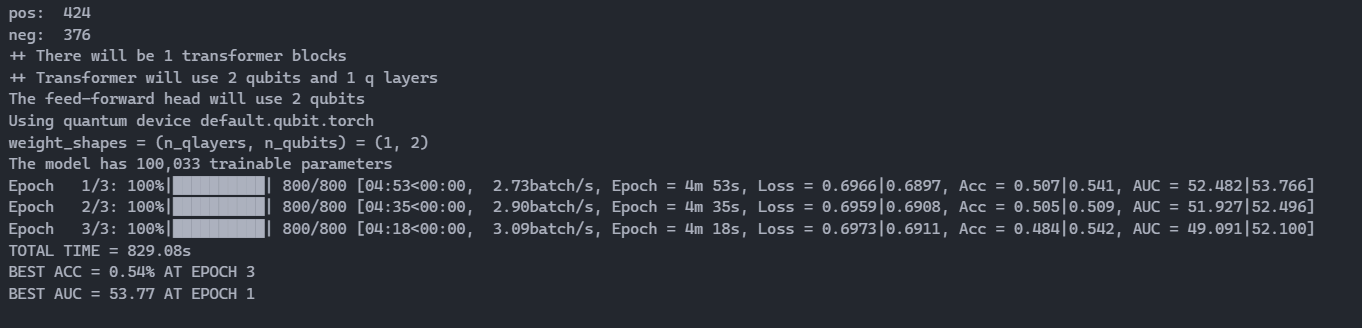

## Evaluation


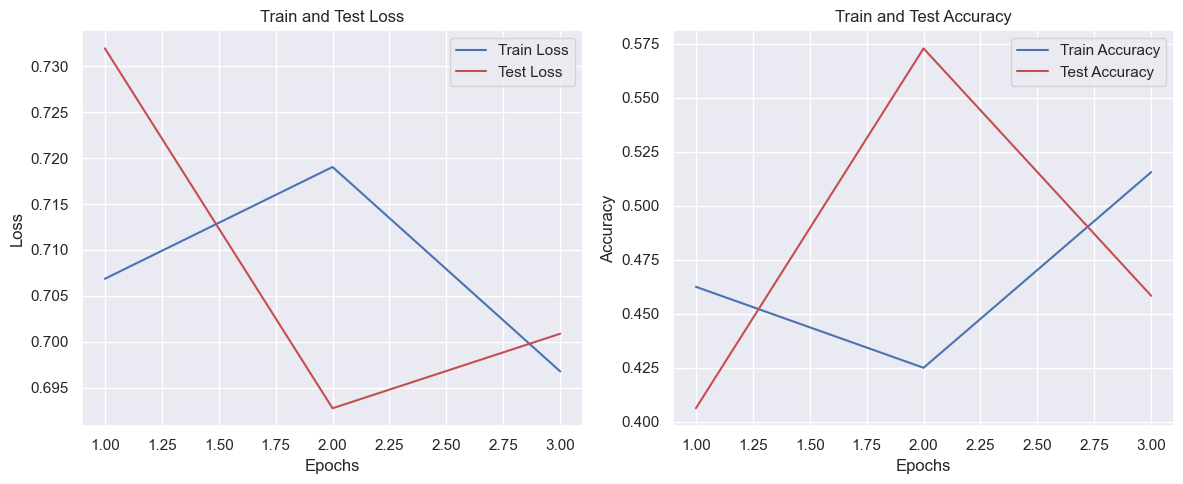

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# plt.style.use("classic")
# plt.style.use("dark_background")

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, "b-", label="Train Loss")
plt.plot(epochs, test_loss, "r-", label="Test Loss")
plt.title("Train and Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, "b-", label="Train Accuracy")
plt.plot(epochs, test_acc, "r-", label="Test Accuracy")
plt.title("Train and Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

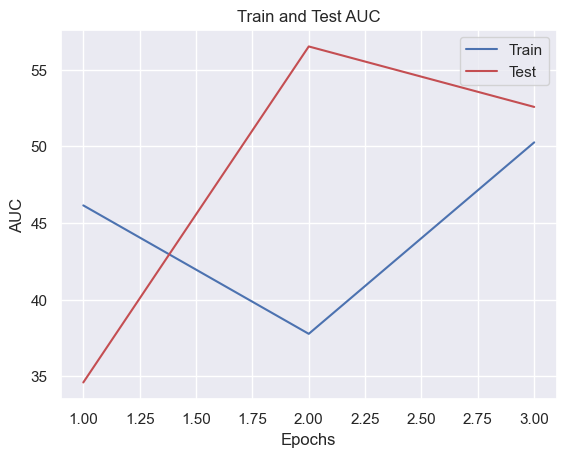

In [ ]:
plt.plot(epochs, train_auc, "b-", label="Train")
plt.plot(epochs, test_auc, "r-", label="Test")
plt.title("Train and Test AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [ ]:
# checkpoint = torch.load(
#     ".models/model_and_metrics_epoch_10.pt"
# )  # Replace x with the epoch number

# # Load the metrics
# epoch = checkpoint["epoch"]
# train_loss = checkpoint["train_loss"]
# train_acc = checkpoint["train_acc"]
# train_auc = checkpoint["train_auc"]
# test_loss = checkpoint["test_loss"]
# test_acc = checkpoint["test_acc"]
# test_auc = checkpoint["test_auc"]

# test_acc

In [ ]:
# fig, ax = plt.subplots(figsize=(4, 3.5))
# # ax.plot(classical_qg_metrics['train_aucs'], label='Classical Training', color='orange', linestyle='--')
# # ax.plot(quantum_qg_metrics['train_aucs'], label='Quantum Training', color='purple', linestyle='--')
# # ax.plot(classical_qg_metrics['val_aucs'], label='Classical Validation', color='orange')
# # ax.plot(quantum_qg_metrics['val_aucs'], label='Quantum Validation', color='purple')
# ax.plot(auc, label="Quantum Validation", color="purple")
# ax.set_xlabel("Epoch")
# ax.set_ylabel("AUC")
# ax.legend()
# ax.grid()
# ax.set_ylim(0.5, 1)